In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import solvers
from cvxopt import matrix
import plotly.express as px

ds = pd.read_csv('portfolio.csv')
ds.drop('Date', axis='columns', inplace=True)

dat = np.array(ds)
data=np.array(ds)
for i in range(len(dat)):
    data[len(dat)-1-i]=dat[i]


plt.rcParams["figure.figsize"] = (8,5)
period=24
date=["April 2020","May 2020","June 2020","July 2020","August 2020","September 2020","October 2020","November 2020","December 2020","January 2021","February 2021","March 2021","April 2021","May 2021","June 2021","July 2021","August 2021","September 2021","October 2021","November 2021","December 2021","January 2022","February 2022","March 2022"]
mon=pd.DataFrame()
ratio=pd.DataFrame()
avg_ret=pd.DataFrame()
avg_rat=pd.DataFrame()
mon["Date"]=pd.DataFrame(date)
ratio["Date"]=pd.DataFrame(date)
avg_ret["  "]=pd.DataFrame(["Average Return","Standard Deviation"])
avg_rat["  "]=pd.DataFrame(["Average Ratio"])
# Mean-Variance Model
def MarkowitzModel(num):
    ret = np.copy(data)
    ret=ret[:num]
    
    for i in range(1, ret.shape[0]):
        ret[i] = (data[i] - data[i-1])/data[i-1]
        
    ret = ret[1:, :]
    retm = ret - np.mean(ret, axis=0)
    
    omega = np.dot(retm.T, retm)/(np.shape(retm)[0])
    
    omega=np.cov(ret.T)
    e = np.ones((30, 1))
    x = np.dot(np.linalg.inv(omega), e)
    
    weight = x/(np.dot(e.T, x))
    
    return weight

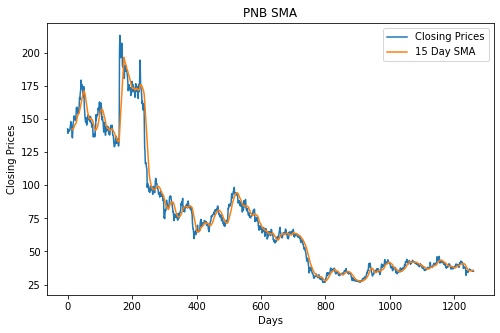

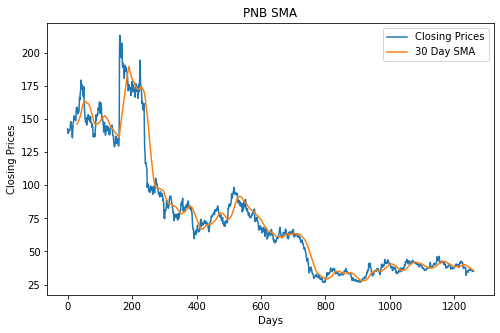

In [2]:
#Optimization to determine weight monthly then C2MM to maintain the portfolio

name=list(ds[0:0])
df=pd.DataFrame()
for i in range(len(name)):
    val=[]
    for j in range(len(data)):
        val.append(data[j][i])
    df[name[i]]=val

window1 = 15
sma1 = pd.DataFrame()
for val in name:    
    sma1[val] = df[val].rolling(window = window1).mean()

# Plotting 15 day sma for PNB
plt.title('PNB' + ' SMA')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['PNB'], label='Closing Prices')
plt.plot(sma1['PNB'], label='15 Day SMA')
plt.legend()
plt.show()

window2 = 30
sma2 = pd.DataFrame()
for val in name:
    sma2[val] = df[val].rolling(window = window2).mean()

# Plotting 30 day sma for PNB
plt.title('PNB' + ' SMA')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['PNB'], label='Closing Prices')
plt.plot(sma2['PNB'], label='30 Day SMA')
plt.legend()
plt.show()

signl = dict(pd.DataFrame())
for val in name:
    signl[val]={}
    signl[val][val] = df[val]
    signl[val]['SMA'+str(window1)] = sma1[val]
    signl[val]['SMA'+str(window2)] = sma2[val]



In [3]:
#Optimization to determine weight monthly then C2MM to maintain the portfolio

def dualMACrossover(signl,val):
    sigPriceBuy = []
    sigPriceSell = []
    flag = -1 # Flag denoting when the 2 moving averages crossed each other
    for i in range(len(signl[val])):
        if signl['SMA'+str(window1)][i] > signl['SMA'+str(window2)][i]:
            if flag != 1:
                sigPriceBuy.append(signl[val][i])
                sigPriceSell.append(0)
                flag = 1
            else:
                sigPriceBuy.append(0)
                sigPriceSell.append(0)
        elif signl['SMA'+str(window1)][i] < signl['SMA'+str(window2)][i]:
            if flag!=0:
                sigPriceBuy.append(0)
                sigPriceSell.append(signl[val][i])
                flag=0
            else:
                sigPriceBuy.append(0)
                sigPriceSell.append(0)
        else:
            sigPriceBuy.append(0)
            sigPriceSell.append(0)
    return (sigPriceBuy,sigPriceSell)

for val in name:
    buy_sell = dualMACrossover(signl[val],val)
    signl[val]['BuySignalPrice'] = buy_sell[0]
    signl[val]['SellSignalPrice'] = buy_sell[1]

mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    for i in range(len(weight)):
        if weight[i]>0:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    
    for i in range(len(name)):
        val=name[i]
        last=signl[val][val][index]
        prof=0
        flag=1
        for k in range(30):
            if flag==1 and signl[val]['SellSignalPrice'][index+k]>0:
                prof=prof+signl[val]['SellSignalPrice'][index+k]-last
                last=0
                flag=0
            if flag==0 and signl[val]['BuySignalPrice'][index+k]>0:
                last=signl[val]['BuySignalPrice'][index+k]
                flag=1
        if flag==1:
            prof=prof+signl[val][val][index+29]-last

        mon_ret[j][0]=mon_ret[j][0]+weight[i]*(prof/signl[val][val][index])

mon["C2MM POTA"]=pd.DataFrame(mon_ret)
ratio["C2MM POTA"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["C2MM POTA"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])
avg_rat["C2MM POTA"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])
print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.02768322]
 [-0.04256799]
 [ 0.01009697]
 [ 0.08821355]
 [-0.00792517]
 [ 0.01877296]
 [-0.05234908]
 [-0.01750554]
 [-0.02738772]
 [ 0.07963181]
 [ 0.0075714 ]
 [ 0.02125845]
 [ 0.08827143]
 [ 0.10719422]
 [ 0.00178587]
 [ 0.03592901]
 [ 0.07055713]
 [ 0.05313119]
 [ 0.07943258]
 [ 0.04029179]
 [-0.02267173]
 [-0.00196408]
 [-0.0422494 ]
 [-0.0462967 ]]
average return [0.01953767]
standard deviation [0.04704622]


In [4]:
#Technical Analysis using C2MM to filter out the stocks and then Portfolio Optimization to determine weights 

mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    
    sign={}
    for i in range(len(name)):
        val=name[i]
        prof=0
        flag=0
        for k in range(30):
            if signl[val]['SellSignalPrice'][index+k]>0:
                flag=0
            if signl[val]['BuySignalPrice'][index+k]>0:
                flag=1

        sign[val]=flag


    for i in range(len(weight)):
        if weight[i]>0 and sign[name[i]]==1:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0 and sign[name[i]]==1:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    for i in range(30):
        val=name[i]
        mon_ret[j][0]=mon_ret[j][0]+weight[i]*((signl[val][val][index+29]-signl[val][val][index])/signl[val][val][index])

mon["C2MM TAPO"]=pd.DataFrame(mon_ret)
ratio["C2MM TAPO"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["C2MM TAPO"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])

avg_rat["C2MM TAPO"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])
print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.06015614]
 [ 0.03676202]
 [ 0.04033758]
 [ 0.12463193]
 [ 0.04901896]
 [ 0.04513267]
 [-0.02322422]
 [ 0.0505869 ]
 [ 0.01803626]
 [ 0.11151074]
 [ 0.05729547]
 [ 0.0776278 ]
 [ 0.11356323]
 [ 0.16851195]
 [ 0.08952656]
 [ 0.07913671]
 [ 0.11983906]
 [ 0.10571554]
 [ 0.08614219]
 [ 0.09145231]
 [ 0.01537522]
 [ 0.05083341]
 [ 0.05426473]
 [ 0.01903933]]
average return [0.06838635]
standard deviation [0.04208924]


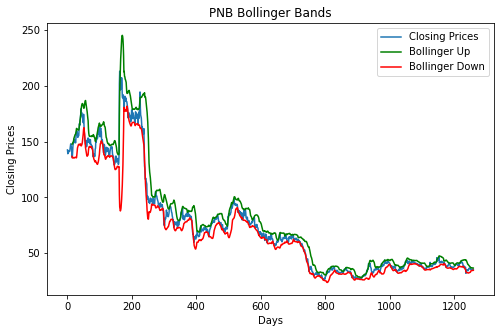

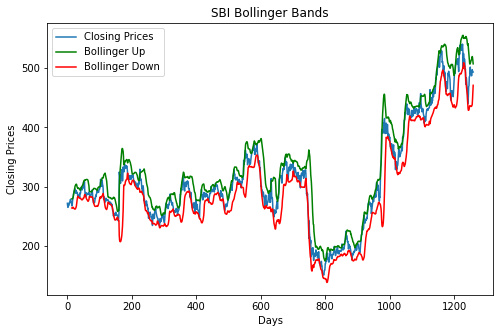

In [5]:
#Optimization to determine weight monthly then Bollinger Bands to maintain the portfolio

def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=15):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std *2 # Calculate top band
    bollinger_down = sma - std *2 # Calculate bottom band
    return bollinger_up, bollinger_down

bollinger_up={}
bollinger_down={}

for val in name:
    bollinger_up[val], bollinger_down[val] = get_bollinger_bands(df[val])

plt.title('PNB' + ' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['PNB'], label='Closing Prices')
plt.plot(bollinger_up['PNB'], label='Bollinger Up', c='g')
plt.plot(bollinger_down['PNB'], label='Bollinger Down', c='r')
plt.legend()
plt.show()
plt.title('SBI' + ' Bollinger Bands')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.plot(df['SBI'], label='Closing Prices')
plt.plot(bollinger_up['SBI'], label='Bollinger Up', c='g')
plt.plot(bollinger_down['SBI'], label='Bollinger Down', c='r')
plt.legend()
plt.show()

In [6]:
#Optimization to determine weight monthly then Bollinger Bands to maintain the portfolio

mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    for i in range(len(weight)):
        if weight[i]>0:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    
    for i in range(len(name)):
        val=name[i]
        last=signl[val][val][index]
        prof=0
        flag=1
        for k in range(30):
            if flag==1 and signl[val][val][index+k]>bollinger_up[val][index+k]:
                prof=prof+signl[val][val][index+k]-last
                last=0
                flag=0
            if flag==0 and signl[val][val][index+k]<bollinger_down[val][index+k]:
                last=signl[val][val][index+k]
                flag=1
        if flag==1:
            prof=prof+signl[val][val][index+29]-last

        mon_ret[j][0]=mon_ret[j][0]+weight[i]*(prof/signl[val][val][index])
mon["Bollinger Bands POTA"]=pd.DataFrame(mon_ret)
ratio["Bollinger Bands POTA"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["Bollinger Bands POTA"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])
avg_rat["Bollinger Bands POTA"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])
print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.03190679]
 [-0.05177969]
 [-0.00127836]
 [ 0.09312071]
 [-0.0718498 ]
 [ 0.00364123]
 [-0.14926331]
 [-0.00953039]
 [ 0.00641   ]
 [ 0.07466494]
 [ 0.01633672]
 [ 0.00089881]
 [ 0.04614446]
 [ 0.0653059 ]
 [-0.00828796]
 [ 0.02382518]
 [ 0.04049101]
 [ 0.00525092]
 [ 0.00575943]
 [ 0.03285995]
 [ 0.02538412]
 [ 0.00311252]
 [-0.00698926]
 [-0.022546  ]]
average return [0.0063995]
standard deviation [0.04823588]


In [7]:
#Technical Analysis using Bollinger Bands to filter out the stocks and then Portfolio Optimization to determine weights 

mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    
    sign={}
    for i in range(len(name)):
        val=name[i]
        prof=0
        flag=0
        for k in range(30):
            if signl[val][val][index+k]>bollinger_up[val][index+k]:
                flag=0
            if signl[val][val][index+k]<bollinger_down[val][index+k]:
                flag=1

        sign[val]=flag


    for i in range(len(weight)):
        if weight[i]>0 and sign[name[i]]==1:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0 and sign[name[i]]==1:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    for i in range(30):
        val=name[i]
        mon_ret[j][0]=mon_ret[j][0]+weight[i]*((signl[val][val][index+29]-signl[val][val][index])/signl[val][val][index])
mon["Bollinger Bands TAPO"]=pd.DataFrame(mon_ret)

ratio["Bollinger Bands TAPO"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["Bollinger Bands TAPO"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])
avg_rat["Bollinger Bands TAPO"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])

print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[-0.01334968]
 [-0.11576692]
 [-0.03766364]
 [ 0.12313376]
 [-0.16717921]
 [-0.0404063 ]
 [-0.17350384]
 [-0.03649126]
 [-0.07928583]
 [ 0.00560968]
 [-0.03242624]
 [-0.06403233]
 [-0.02825368]
 [ 0.04268976]
 [-0.05590624]
 [-0.06477994]
 [ 0.00764356]
 [-0.04361092]
 [-0.05085828]
 [-0.01548813]
 [-0.07533264]
 [-0.04584505]
 [-0.06877512]
 [-0.04584929]]
average return [-0.04482199]
standard deviation [0.05907934]


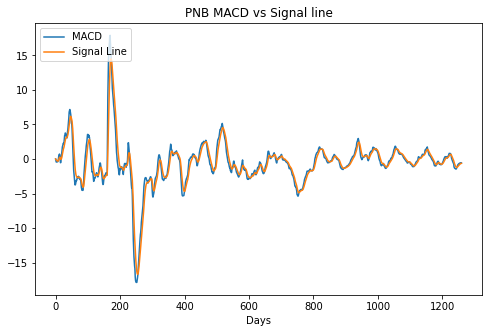

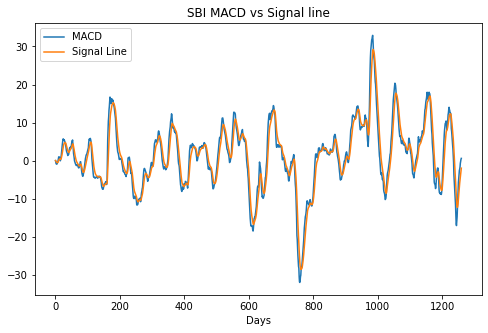

In [8]:
#Optimization to determine weight monthly then MACD to maintain the portfolio

exp1=pd.DataFrame()
exp2=pd.DataFrame()
exp3=pd.DataFrame()
macd=pd.DataFrame()

for val in name:    
    exp1[val] = df[val].ewm(span=12, adjust=False).mean()
    exp2[val] = df[val].ewm(span=26, adjust=False).mean()
    macd[val] = exp1[val]-exp2[val]
    exp3[val] = macd[val].ewm(span=9, adjust=False).mean()

#plotting macd vs Signal line for PNB stock
plt.title('PNB' + ' MACD vs Signal line')
plt.plot( macd['PNB'], label='MACD')
plt.plot( exp3['PNB'], label='Signal Line')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.show()
plt.title('SBI' + ' MACD vs Signal line')
plt.plot( macd['SBI'], label='MACD')
plt.plot( exp3['SBI'], label='Signal Line')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.show()

In [9]:
#Optimization to determine weight monthly then MACD to maintain the portfolio
mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    for i in range(len(weight)):
        if weight[i]>0:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    
    for i in range(len(name)):
        val=name[i]
        last=signl[val][val][index]
        prof=0
        flag=1
        for k in range(30):
            if flag==1 and exp3[val][index+k]<macd[val][index+k]:
                prof=prof+signl[val][val][index+k]-last
                last=0
                flag=0
            if flag==0 and exp3[val][index+k]>macd[val][index+k]:
                last=signl[val][val][index+k]
                flag=1
        if flag==1:
            prof=prof+signl[val][val][index+29]-last

        mon_ret[j][0]=mon_ret[j][0]+weight[i]*(prof/signl[val][val][index])

mon["MACD POTA"]=pd.DataFrame(mon_ret)
ratio["MACD POTA"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["MACD POTA"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])
avg_rat["MACD POTA"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])

print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.03039633]
 [-0.03908356]
 [ 0.01784751]
 [ 0.08373203]
 [-0.0610057 ]
 [ 0.02074268]
 [-0.15141297]
 [-0.10023263]
 [ 0.045606  ]
 [ 0.07000167]
 [ 0.02457397]
 [ 0.03730967]
 [ 0.02389706]
 [ 0.05153203]
 [-0.006753  ]
 [ 0.03411368]
 [ 0.02945407]
 [ 0.00238124]
 [ 0.02256623]
 [-0.00650295]
 [-0.00808842]
 [-0.00115479]
 [-0.01889018]
 [-0.00169386]]
average return [0.00413901]
standard deviation [0.05072701]


In [10]:
#Technical Analysis using MACD to filter out the stocks and then Portfolio Optimization to determine weights 

mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    
    sign={}
    for i in range(len(name)):
        val=name[i]
        prof=0
        flag=0
        for k in range(30):
            if exp3[val][index+k]<macd[val][index+k]:
                flag=0
            if exp3[val][index+k]>macd[val][index+k]:
                flag=1

        sign[val]=flag


    for i in range(len(weight)):
        if weight[i]>0 and sign[name[i]]==1:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0 and sign[name[i]]==1:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    for i in range(30):
        val=name[i]
        mon_ret[j][0]=mon_ret[j][0]+weight[i]*((signl[val][val][index+29]-signl[val][val][index])/signl[val][val][index])
mon["MACD TAPO"]=pd.DataFrame(mon_ret)

ratio["MACD TAPO"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["MACD TAPO"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])
avg_rat["MACD TAPO"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])
print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.04007838]
 [-0.0902608 ]
 [ 0.02326158]
 [ 0.15875089]
 [-0.18513466]
 [-0.02661666]
 [-0.17246297]
 [ 0.01752614]
 [-0.0116283 ]
 [ 0.05544303]
 [ 0.02944832]
 [ 0.11287756]
 [ 0.11218811]
 [ 0.08535829]
 [-0.03272556]
 [-0.05252651]
 [ 0.06141314]
 [ 0.00825908]
 [ 0.01436618]
 [ 0.02261752]
 [-0.05259981]
 [ 0.02475258]
 [-0.03190849]
 [-0.07527415]]
average return [0.00146679]
standard deviation [0.08052431]


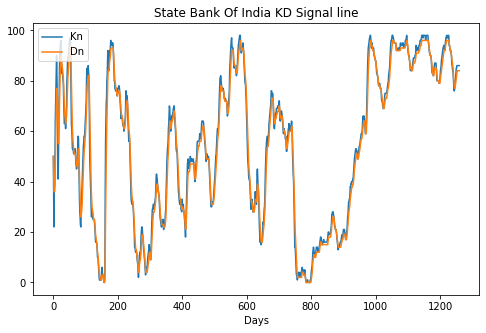

In [11]:
#Optimization to determine weight monthly then KD Index to maintain the portfolio

high = np.copy(data)
high = high[:1]
low = np.copy(high)
Kn = np.full((1260,30),50)
for i in range(1,1260):
    cur = np.copy(data)
    cur = cur[i:i+1]
    for j in range(30):
        if high[0][j]<data[i][j]:
            high[0][j]=data[i][j]
        if low[0][j]>data[i][j]:
            low[0][j]=data[i][j]
        
        rsv = (cur[0][j] - low[0][j])/(high[0][j]-low[0][j])
        rsv=rsv*100
        Kn[i][j] = (rsv/3) + (Kn[i-1][j]*2)/3
        
#print("Kn",Kn)

Dn = np.full((1260,30),50)
for i in range(1,1260):
    for j in range(30):
        Dn[i][j] = (Kn[i][j]/3) + (Dn[i-1][j]*2)/3
        
#print("Dn",Dn)
k=[]
d=[]
for i in range(len(Kn)):
    k.append(Kn[i][2])
    d.append(Dn[i][2])
#plotting K vs D Signal line for SBI stock
plt.title('State Bank Of India' + ' KD Signal line')
plt.plot( k, label='Kn')
plt.plot( d, label='Dn')
plt.xlabel('Days')
plt.legend(loc='upper left')
plt.show()

In [12]:
#Optimization to determine weight monthly then KD Index to maintain the portfolio

mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    for i in range(len(weight)):
        if weight[i]>0:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    
    for i in range(len(name)):
        val=name[i]
        last=signl[val][val][index]
        prof=0
        flag=1
        for k in range(30):
            if flag==1 and Kn[index-1][i]>=Dn[index-1][i] and Kn[index][i]<Dn[index][i]:
                prof=prof+signl[val][val][index+k]-last
                last=0
                flag=0
            if flag==0 and Kn[index-1][i]<=Dn[index-1][i] and Kn[index][i]>Dn[index][i]:
                last=signl[val][val][index+k]
                flag=1
        if flag==1:
            prof=prof+signl[val][val][index+29]-last

        mon_ret[j][0]=mon_ret[j][0]+weight[i]*(prof/signl[val][val][index])

mon["IFR POTA"]=pd.DataFrame(mon_ret)
ratio["IFR POTA"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["IFR POTA"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])
avg_rat["IFR POTA"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])

print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.03098652]
 [-0.08174034]
 [ 0.00484673]
 [ 0.07041909]
 [-0.06607725]
 [ 0.01746067]
 [-0.17350384]
 [ 0.00837506]
 [ 0.02051603]
 [ 0.07291608]
 [ 0.01526843]
 [ 0.02586787]
 [ 0.10771145]
 [ 0.11189202]
 [-0.00463951]
 [ 0.0012612 ]
 [ 0.08894696]
 [ 0.04127051]
 [ 0.0780185 ]
 [ 0.03335261]
 [-0.04239935]
 [-0.00201702]
 [-0.04645434]
 [-0.03092802]]
average return [0.01172292]
standard deviation [0.06347099]


In [13]:
#Technical Analysis using C2MM to filter out the stocks and then Portfolio Optimization to determine weights 

mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    
    sign={}
    for i in range(len(name)):
        val=name[i]
        prof=0
        flag=0
        for k in range(30):
            if Kn[index-1][i]>=Dn[index-1][i] and Kn[index][i]<Dn[index][i]:
                flag=0
            if Kn[index-1][i]<=Dn[index-1][i] and Kn[index][i]>Dn[index][i]:
                flag=1

        sign[val]=flag


    for i in range(len(weight)):
        if weight[i]>0 and sign[name[i]]==1:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0 and sign[name[i]]==1:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    for i in range(30):
        val=name[i]
        mon_ret[j][0]=mon_ret[j][0]+weight[i]*((signl[val][val][index+29]-signl[val][val][index])/signl[val][val][index])
mon["IFR TAPO"]=pd.DataFrame(mon_ret)
ratio["IFR TAPO"]=pd.DataFrame(mon_ret/np.std(mon_ret,axis=0))
avg_ret["IFR TAPO"]=pd.DataFrame([np.mean(mon_ret, axis=0),np.std(mon_ret,axis=0)])
avg_rat["IFR TAPO"]=pd.DataFrame([np.mean((mon_ret/np.std(mon_ret,axis=0)), axis=0)])

print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.03710086]
 [-0.02236951]
 [ 0.06879146]
 [ 0.13910556]
 [-0.06721545]
 [ 0.01182652]
 [-0.02322422]
 [-0.08812958]
 [ 0.09186352]
 [ 0.08066353]
 [ 0.00349732]
 [ 0.02220117]
 [-0.05226976]
 [ 0.11287492]
 [-0.07044791]
 [-0.00772493]
 [ 0.12409892]
 [ 0.04973019]
 [ 0.11057413]
 [ 0.20802637]
 [-0.07964865]
 [-0.00222912]
 [-0.06576274]
 [-0.1936328 ]]
average return [0.01615416]
standard deviation [0.08901056]


In [14]:
mon_ret = np.zeros((period,1))
for j in range(period):
    index=1260-(period-j)*30
    weight = MarkowitzModel(index)
    divisible=0.0
    for i in range(len(weight)):
        if weight[i]>0:
            divisible=divisible+weight[i]
    for i in range(len(weight)):
        if divisible==0:
            continue
        if weight[i]>0:
            weight[i]=weight[i]/divisible
        else:
            weight[i]=0
    
    for i in range(30):
        
        prof=signl[val][val][index+29]-signl[val][val][index]
        prof=prof/2
        mon_ret[j][0]=mon_ret[j][0]+weight[i]*(prof/signl[val][val][index])

print("monthly return",mon_ret)
print("average return",np.mean(mon_ret, axis=0))
print("standard deviation",np.std(mon_ret,axis=0))

monthly return [[ 0.04963381]
 [-0.01026875]
 [-0.02308187]
 [ 0.1038478 ]
 [ 0.00901348]
 [ 0.03187474]
 [-0.01161211]
 [ 0.01301694]
 [ 0.06725146]
 [ 0.18248978]
 [-0.08756149]
 [ 0.05832496]
 [-0.03083181]
 [ 0.03509   ]
 [ 0.03136988]
 [-0.04847027]
 [ 0.04905742]
 [ 0.08484848]
 [-0.01778035]
 [ 0.00742716]
 [ 0.00056673]
 [ 0.00420539]
 [-0.05847057]
 [-0.0088659 ]]
average return [0.01796146]
standard deviation [0.05606802]


In [15]:
mon

,Date,C2MM POTA,C2MM TAPO,Bollinger Bands POTA,Bollinger Bands TAPO,MACD POTA,MACD TAPO,IFR POTA,IFR TAPO
0,April 2020,0.027683,0.060156,0.031907,-0.013350,0.030396,0.040078,0.030987,0.037101
1,May 2020,-0.042568,0.036762,-0.051780,-0.115767,-0.039084,-0.090261,-0.081740,-0.022370
2,June 2020,0.010097,0.040338,-0.001278,-0.037664,0.017848,0.023262,0.004847,0.068791
3,July 2020,0.088214,0.124632,0.093121,0.123134,0.083732,0.158751,0.070419,0.139106
4,August 2020,-0.007925,0.049019,-0.071850,-0.167179,-0.061006,-0.185135,-0.066077,-0.067215
5,September 2020,0.018773,0.045133,0.003641,-0.040406,0.020743,-0.026617,0.017461,0.011827
6,October 2020,-0.052349,-0.023224,-0.149263,-0.173504,-0.151413,-0.172463,-0.173504,-0.023224
7,November 2020,-0.017506,0.050587,-0.009530,-0.036491,-0.100233,0.017526,0.008375,-0.088130
8,December 2020,-0.027388,0.018036,0.006410,-0.079286,0.045606,-0.011628,0.020516,0.091864
9,January 2021,0.079632,0.111511,0.074665,0.005610,0.070002,0.055443,0.072916,0.080664


In [16]:
avg_ret

,,C2MM POTA,C2MM TAPO,Bollinger Bands POTA,Bollinger Bands TAPO,MACD POTA,MACD TAPO,IFR POTA,IFR TAPO
0,Average Return,0.019538,0.068386,0.006399,-0.044822,0.004139,0.001467,0.011723,0.016154
1,Standard Deviation,0.047046,0.042089,0.048236,0.059079,0.050727,0.080524,0.063471,0.089011


In [17]:
ratio

,Date,C2MM POTA,C2MM TAPO,Bollinger Bands POTA,Bollinger Bands TAPO,MACD POTA,MACD TAPO,IFR POTA,IFR TAPO
0,April 2020,0.588426,1.429252,0.661474,-0.225962,0.599214,0.497718,0.488200,0.416814
1,May 2020,-0.904812,0.873430,-1.073468,-1.959516,-0.770468,-1.120914,-1.287838,-0.251313
2,June 2020,0.214618,0.958382,-0.026502,-0.637510,0.351834,0.288876,0.076361,0.772846
3,July 2020,1.875040,2.961135,1.930528,2.084210,1.650640,1.971466,1.109469,1.562798
4,August 2020,-0.168455,1.164644,-1.489551,-2.829741,-1.202628,-2.299115,-1.041062,-0.755140
5,September 2020,0.399032,1.072309,0.075488,-0.683933,0.408908,-0.330542,0.275097,0.132866
6,October 2020,-1.112716,-0.551785,-3.094446,-2.936794,-2.984859,-2.141750,-2.733593,-0.260915
7,November 2020,-0.372092,1.201896,-0.197579,-0.617665,-1.975922,0.217650,0.131951,-0.990103
8,December 2020,-0.582145,0.428524,0.132889,-1.342023,0.899048,-0.144407,0.323235,1.032052
9,January 2021,1.692629,2.649388,1.547913,0.094952,1.379968,0.688525,1.148810,0.906224


In [18]:
avg_rat

,,C2MM POTA,C2MM TAPO,Bollinger Bands POTA,Bollinger Bands TAPO,MACD POTA,MACD TAPO,IFR POTA,IFR TAPO
0,Average Ratio,0.415287,1.624794,0.132671,-0.758675,0.081594,0.018215,0.184697,0.181486
